#### Rock Shi Churn Prediction Capstone

In [21]:
# Importing all packages needed

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import when
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import confusion_matrix
from pyspark.sql.types import *
from plotly.offline import init_notebook_mode, iplot
import plotly_express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import scipy.stats as stats


In [27]:
# Reading in datasets from hadoop
churn_df = spark.read.csv('/spark/input/Telco-Customer-Churn.csv', inferSchema = True, header = True)

In [3]:
# Displaying first five rows of train dataset
churn_df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [28]:
# Caching Data
churn_df.cache()

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]

In [80]:
# Printing schema of data
churn_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



### Data Cleaning

In [5]:
# Seeing the number of null values present
churn_df.select([count(when(isnull(c),c)).alias(c) for c in churn_df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

### EDA

In [29]:
# Converting Spark Dataframe to Pandas Dataframe
churn_pd_df = churn_df.toPandas()

In [17]:
# Subplotting Distribution of Data
fig = make_subplots(rows=1, cols=2, subplot_titles = ('Distribution of Senior Citizen', 'Distribution of Gender'), start_cell="bottom-left")

fig.add_trace(go.Histogram(x = churn_pd_df['SeniorCitizen'], histnorm = 'percent'),row=1, col=1)

fig.add_trace(go.Histogram(x = churn_pd_df['gender'], histnorm = 'percent'),row=1, col=2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

'''fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")

fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
              row=1, col=2)

fig.add_trace(go.Scatter(x=[300, 400, 500], y=[600, 700, 800]),
              row=2, col=1)

fig.add_trace(go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000]),
              row=2, col=2)

fig.show()'''

'fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")\n\nfig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),\n              row=1, col=1)\n\nfig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),\n              row=1, col=2)\n\nfig.add_trace(go.Scatter(x=[300, 400, 500], y=[600, 700, 800]),\n              row=2, col=1)\n\nfig.add_trace(go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000]),\n              row=2, col=2)\n\nfig.show()'

In [89]:
# Impact of Seniority on Churn
fig = px.histogram(churn_pd_df, x="SeniorCitizen", color="Churn", barmode='group', title = 'Impact of Seniority on Churn') 
fig.show()

In [90]:
# Impact of Contract Type on Churn
fig = px.histogram(churn_pd_df, x="Contract", color="Churn", barmode='group', title = 'Impact of Contract Type on Churn') 
fig.show()

In [94]:
# Treemap
treemap_df = churn_pd_df
treemap_df['Partner'].replace(to_replace='Yes', value='Married', inplace=True)
treemap_df['Partner'].replace(to_replace='No',  value='Not Married', inplace=True)
treemap_df['SeniorCitizen'].replace(to_replace=1, value='Senior', inplace=True)
treemap_df['SeniorCitizen'].replace(to_replace=0,  value='Not Senior', inplace=True)
fig = px.treemap(treemap_df, path = ['Churn','Partner','SeniorCitizen'])
fig.show()

### Hypothesis Testing

In [26]:
# Getting unique values for contract type
churn_pd_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [30]:
# get_dummies for churn
churn = pd.get_dummies(churn_pd_df['Churn'])
churn_pd_df = pd.concat([churn_pd_df, churn], axis = 1)
churn_pd_df.drop(['Churn', 'No'], axis = 1, inplace = True)
churn_pd_df = churn_pd_df.rename(columns = {'Yes': 'Churn'})

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


In [33]:
# Testing if contract type will have impact on churn (1-way Anova)
mtm_df = churn_pd_df[churn_pd_df.Contract == 'Month-to-month']
oy_df = churn_pd_df[churn_pd_df.Contract == 'One year']
ty_df = churn_pd_df[churn_pd_df.Contract == 'Two year']

f_stat, p_value = stats.f_oneway(mtm_df['Churn'],oy_df['Churn'],ty_df['Churn'])

print('f_stat:', f_stat)
print('p_value:', p_value)

if p_value <= 0.05:
    print("Contract types have an effect on Churn.")
else:
    print("Contract types do not have an effect on Churn.")

f_stat: 711.7604625631104
p_value: 2.9921663019905003e-282
Contract types have an effect on Churn.


In [34]:
# Getting unique values for gender
churn_pd_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [35]:
# testing gender impact on churn
male_df = churn_pd_df[churn_pd_df.gender == 'Male']
female_df = churn_pd_df[churn_pd_df.gender == 'Female']

statistics, p_value = stats.ttest_ind(male_df['Churn'], female_df['Churn'])

print('Statistics:', statistics)
print('p_value:', p_value)


if p_value <= 0.05:
    print("Gender has an impact on Churn.")
else:
    print("Gender has no impact on Churn.")

Statistics: -0.722673440663404
p_value: 0.46990453909804797
Gender has no impact on Churn.


In [36]:
# Getting unique values for gender
churn_pd_df['SeniorCitizen'].unique()

array([0, 1])

In [37]:
# testing if being a senior citizen impacts churn
senior_df = churn_pd_df[churn_pd_df.SeniorCitizen == 1]
not_senior_df = churn_pd_df[churn_pd_df.SeniorCitizen == 0]

statistics, p_value = stats.ttest_ind(senior_df['Churn'], not_senior_df['Churn'])

print('Statistics:', statistics)
print('p_value:', p_value)


if p_value <= 0.05:
    print("Seniority has an impact on Churn.")
else:
    print("Seniority has no impact on Churn.")

Statistics: 12.807865726034748
p_value: 3.839860055784895e-37
Seniority has an impact on Churn.


# Prepping Data for ML

In [44]:
# Changing categorical values to index values
indexers = [StringIndexer(inputCol = column, outputCol=column+"_index").fit(churn_df) for column in ["gender","Partner", "Dependents","PhoneService","MultipleLines", 
                                                                                                  "InternetService","OnlineSecurity", "OnlineBackup","DeviceProtection",
                                                                                                  "TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling",
                                                                                                  "PaymentMethod","TotalCharges","Churn"]]
pipeline = Pipeline(stages=indexers)
churn_df = pipeline.fit(churn_df).transform(churn_df)

In [45]:
# Dropping not indexed columns and customerID
churn_df = churn_df.drop("customerID","gender","Partner", "Dependents","PhoneService","MultipleLines", 
                   "InternetService","OnlineSecurity", "OnlineBackup","DeviceProtection",
                   "TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling",
                   "PaymentMethod","TotalCharges","Churn")

In [46]:
churn_df.toPandas()

,SeniorCitizen,tenure,MonthlyCharges,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,TotalCharges_index,Churn_index
0,0,1,29.85,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,641.0,0.0
1,0,34,56.95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,3305.0,0.0
2,0,2,53.85,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2218.0,1.0
3,0,45,42.30,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,4944.0,0.0
4,0,2,70.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4017.0,1.0
5,0,8,99.65,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1092.0,1.0
6,0,22,89.10,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,5736.0,0.0
7,0,10,29.75,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1038.0,0.0
8,0,28,104.80,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1959.0,1.0
9,0,62,56.15,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2153.0,0.0


In [47]:
# Function to compute correlation matrix
def compute_corr_matrix(df, method = 'pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method = method)
    
    corr_mat_df = pd.DataFrame(corr_mat, columns = df.columns, index = df.columns)
    
    return corr_mat_df

In [48]:
# Correlation Matrix
compute_corr_matrix(churn_df)

,SeniorCitizen,tenure,MonthlyCharges,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,TotalCharges_index,Churn_index
SeniorCitizen,1.000000,0.016567,0.220173,0.001874,0.016479,-0.211185,-0.008576,0.099883,-0.259390,-0.210897,-0.152780,-0.157095,-0.223770,-0.130130,-0.120802,-0.109299,-0.156530,-0.093704,0.007164,0.150889
tenure,0.016567,1.000000,0.247900,-0.005106,0.379697,0.159712,-0.008448,0.242279,-0.033230,0.145298,0.178651,0.178649,0.144459,0.136145,0.140781,0.503232,-0.006152,0.340305,0.177357,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.014569,0.096848,-0.113890,-0.247398,0.146153,-0.905491,-0.621227,-0.538454,-0.513440,-0.597594,-0.423067,-0.424598,-0.034838,-0.352150,-0.074353,0.106352,0.193356
gender_index,0.001874,-0.005106,0.014569,1.000000,0.001808,-0.010517,-0.006488,0.000485,-0.010380,0.003429,0.002032,-0.005092,-0.000985,-0.001156,0.000191,-0.006171,-0.011754,0.005209,0.004452,0.008612
Partner_index,0.016479,0.379697,0.096848,0.001808,1.000000,0.452676,-0.017706,0.090981,0.000132,0.081850,0.087055,0.094451,0.069072,0.080127,0.075779,0.216229,0.014877,0.133115,0.079390,-0.150448
Dependents_index,-0.211185,0.159712,-0.113890,-0.010517,0.452676,1.000000,0.001762,-0.016875,0.179631,0.190523,0.162445,0.156439,0.180832,0.140395,0.125820,0.178429,0.111377,0.123844,0.015134,-0.164221
PhoneService_index,-0.008576,-0.008448,-0.247398,-0.006488,-0.017706,0.001762,1.000000,0.691070,0.093720,-0.125353,-0.150338,-0.138755,-0.123350,-0.171538,-0.165205,0.000955,0.016505,0.004070,-0.004691,-0.011942
MultipleLines_index,0.099883,0.242279,0.146153,0.000485,0.090981,-0.016875,0.691070,1.000000,-0.174989,-0.235021,-0.210372,-0.200463,-0.232155,-0.202414,-0.195815,0.040607,-0.108230,0.030659,0.066910,0.019423
InternetService_index,-0.259390,-0.033230,-0.905491,-0.010380,0.000132,0.179631,0.093720,-0.174989,1.000000,0.764943,0.686403,0.682448,0.760985,0.617704,0.620005,0.203148,0.378108,0.178137,-0.064687,-0.316846
OnlineSecurity_index,-0.210897,0.145298,-0.621227,0.003429,0.081850,0.190523,-0.125353,-0.235021,0.764943,1.000000,0.751661,0.749040,0.791225,0.701976,0.704984,0.275864,0.334003,0.213800,-0.030066,-0.332819


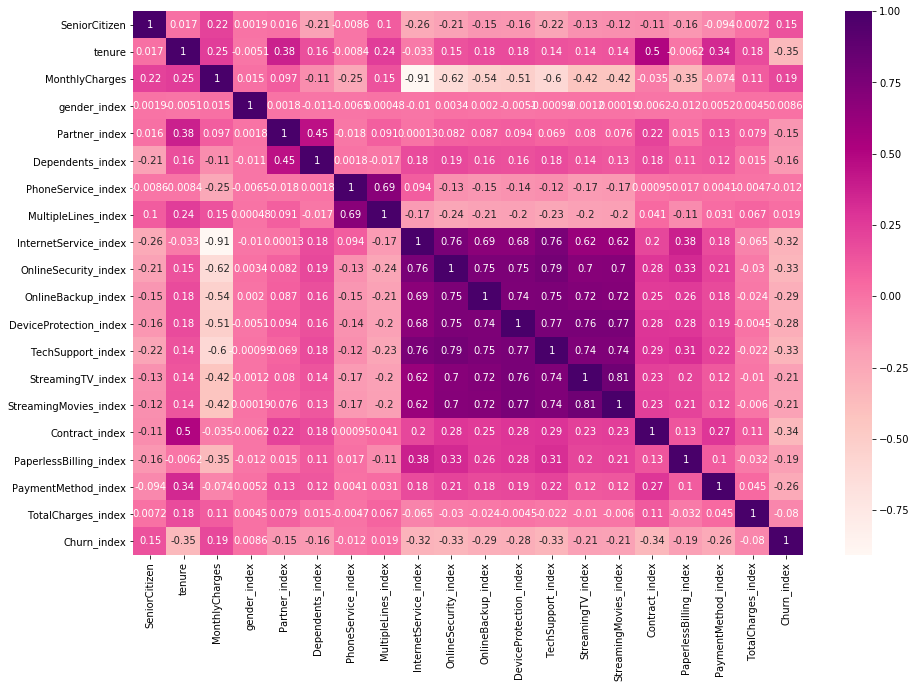

In [49]:
# Heatmap for Correlation Matrix
plt.figure(figsize = (15,10))
sns.heatmap(compute_corr_matrix(churn_df), annot = True, cmap = 'RdPu')

In [50]:
# Creating feature vector using all features except churn
cols = churn_df.columns
cols.remove('Churn_index')

feature = VectorAssembler(inputCols = cols,outputCol = 'features')
churn_df = feature.transform(churn_df)

In [51]:
# Scaling features
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
churn_df=standardscaler.fit(churn_df).transform(churn_df)

In [52]:
# Splitting dataset into 80% 20% train test sets with seed = 1
train, test = churn_df.randomSplit([0.8,0.2], seed = 1)

### Logistic Regression Classifier

In [53]:
# Cloning training and testing specifically for logistic regression classification usage
train_lr = train
test_lr = test

In [54]:
# Calculating number and percentage of positive churn of customers
dataset_size = float(train_lr.select('Churn_index').count())
numPositives = train_lr.select("Churn_index").where("Churn_index == 1.0").count()
per_one = (float(numPositives)/float(dataset_size))*100
print("The number of positive churn are: {}".format(numPositives))
print("Percentage of positive churn are: {}".format(per_one))

The number of positive churn are: 1443
Percentage of positive churn are: 25.850949480472952


In [55]:
# Balance Ratio Calculation
numNegatives = float(dataset_size - numPositives)

BalanceRatio = numNegatives / dataset_size

print("BalanceRatio = {}".format(BalanceRatio))

BalanceRatio = 0.7414905051952705


In [56]:
# Adding class weights
train_lr = train_lr.withColumn("classWeights", when(train_lr.Churn_index == 1.0, BalanceRatio).otherwise(1 - BalanceRatio))

In [57]:
# Adding logistic regression algorithm
logReg = LogisticRegression(labelCol = 'Churn_index', featuresCol = 'Scaled_features', weightCol = 'classWeights', maxIter = 20)

In [58]:
# fitting train to model
model_lr = logReg.fit(train_lr)

In [59]:
# predicting using model trained on train dataset
predict_train_lr = model_lr.transform(train_lr)
predict_test_lr = model_lr.transform(test_lr)

In [60]:
# Showing predictions on test data 
predict_test_lr.select("Churn_index", 'prediction').show()

+-----------+----------+
|Churn_index|prediction|
+-----------+----------+
|        0.0|       0.0|
|        0.0|       1.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
+-----------+----------+
only showing top 20 rows



In [61]:
# Getting accuracy of model
evaluator = MulticlassClassificationEvaluator(labelCol = 'Churn_index', predictionCol = "prediction",
                                             metricName = "accuracy")

accuracy_lr = evaluator.evaluate(predict_test_lr)
print("Accuracy: {}".format(accuracy_lr))

Accuracy: 0.7460643394934976


In [62]:
# Confusion Matrix
y_true_lr = predict_test_lr.select("Churn_index")
y_true_lr = y_true_lr.toPandas()

y_pred_lr = predict_test_lr.select("prediction")
y_pred_lr = y_pred_lr.toPandas()

confusion_mat_lr = confusion_matrix(y_true_lr, y_pred_lr)
confusion_mat_lr

array([[763, 272],
       [ 99, 327]])

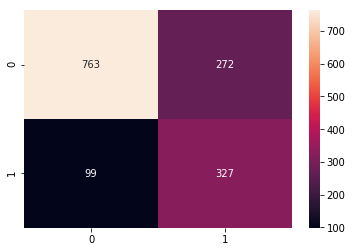

In [63]:
# Heatmap for confusion matrix
sns.heatmap(confusion_mat_lr, annot = True, fmt = '0.0f')

### Decision Tree

In [64]:
# Copying train & test datasets for decision tree classification
train_dt = train
test_dt = test

In [65]:
# Creating decision tree classifier and fitting it to train data
dt = DecisionTreeClassifier(labelCol = 'Churn_index',featuresCol = 'Scaled_features')
dt_model = dt.fit(train_dt)

In [66]:
# predicting churn on test data
dt_prediction = dt_model.transform(test_dt)

In [67]:
# Displaying prediction and actual churn
dt_prediction.select("prediction",'Churn_index').show()

+----------+-----------+
|prediction|Churn_index|
+----------+-----------+
|       0.0|        0.0|
|       0.0|        0.0|
|       0.0|        1.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       0.0|        1.0|
|       0.0|        0.0|
|       0.0|        1.0|
|       0.0|        1.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       0.0|        1.0|
|       0.0|        1.0|
|       0.0|        1.0|
|       0.0|        0.0|
|       0.0|        1.0|
|       0.0|        1.0|
|       0.0|        1.0|
|       0.0|        0.0|
|       0.0|        0.0|
+----------+-----------+
only showing top 20 rows



In [68]:
# Calculating Decision Tree Classification Accuracy
accuracy_dt = evaluator.evaluate(dt_prediction)
print("Accuracy: ", (accuracy_dt))

Accuracy:  0.7727583846680356


In [69]:
# Confusion Matrix
y_true_dt = dt_prediction.select("Churn_index")
y_true_dt = y_true_dt.toPandas()

y_pred_dt = dt_prediction.select("prediction")
y_pred_dt = y_pred_dt.toPandas()

confusion_mat_dt = confusion_matrix(y_true_dt, y_pred_dt)
confusion_mat_dt

array([[943,  92],
       [240, 186]])

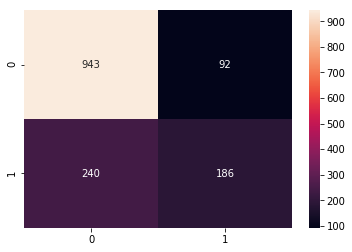

In [70]:
# Confusion Matrix Heatmap
sns.heatmap(confusion_mat_dt, annot = True, fmt = '0.0f')

### Random Forest